# Text to Image generation using DALLE mini

## Install and Settups

In [1]:
# Install required libraries
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git
!pip install -q git+https://github.com/borisdayma/dalle-mini.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 6.7 MB/s 
     |████████████████████████████████| 7.0 MB 30.0 MB/s 
     |████████████████████████████████| 180 kB 8.0 MB/s 
     |████████████████████████████████| 217 kB 69.4 MB/s 
     |████████████████████████████████| 145 kB 70.6 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 
     |████████████████████████████████| 85 kB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 235 kB 9.3 MB/s 
     |████████████████████████████████| 1.8 MB 50.3 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 216 kB 86.4 MB/s 
     |████████████████████████████████| 181 kB 91.9 MB/s 
     |████████████████████████████████| 162 kB 84.4 MB/s 
   

### Loading required models:

* dalle·mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [2]:
# Model references

# dalle-mini
DALLE_MODEL = "dalle-mini/dalle-mini/wzoooa1c:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

# CLIP model
CLIP_REPO = "openai/clip-vit-large-patch14"
CLIP_COMMIT_ID = None

In [3]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [4]:
# Load models & tokenizer (NOTE: This may crash if you run it on your local system. Make sure you have more than 8GB RAM and good amount CPU cores)
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model = DalleBart.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

# Load VQGAN
vqgan = VQModel.from_pretrained(VQGAN_REPO, revision=VQGAN_COMMIT_ID)

# Load CLIP
clip = FlaxCLIPModel.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: ERROR API key must be 40 characters long, yours was 5


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact wzoooa1c:latest, 1672.79MB. 7 files... Done. 0:0:31.5


Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/304M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Replicating model parameters on each device for speedy inference

In [5]:
from flax.jax_utils import replicate

model._params = replicate(model.params)
vqgan._params = replicate(vqgan.params)
clip._params = replicate(clip.params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [6]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


In [7]:
# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

In [8]:
# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

Keys are passed to the model on each device to generate unique inference per device.

In [22]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
random_key = jax.random.PRNGKey(seed)

## Text Prompt

Text prmpts needs to be processed before sending it to model

In [10]:
#from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact wzoooa1c:latest, 1672.79MB. 7 files... Done. 0:0:10.7


Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

Our text prompt for the model

In [11]:
descript = "Dog wearing clothes"

In [12]:
tokenized_prompt = processor([descript])

In [13]:
# Replicating it on devices
tokenized_prompt = replicate(tokenized_prompt)

## Image Generation

Images will be generated using dalle-mini model and decode them with the VQGAN.

In [14]:
# number of predictions
n_predictions = 5

# We can customize top_k/top_p used for generating samples
gen_top_k = None
gen_top_p = None
temperature = 0.85
cond_scale = 3.0

In [16]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange
from flax.training.common_utils import shard

In [ ]:


# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        model.params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan.params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for img in decoded_images:
        images.append(Image.fromarray(np.asarray(img * 255, dtype=np.uint8)))

  0%|          | 0/5 [00:00<?, ?it/s]

In [30]:
def set_img_gen_parameter(npred):
  
  # number of predictions
  n_predictions = npred

  # We can customize top_k/top_p used for generating samples
  gen_top_k = None
  gen_top_p = None
  temperature = 0.85
  cond_scale = 3.0

  return n_predictions, gen_top_k, gen_top_p, temperature, cond_scale 

In [31]:
def generate_text_to_image(description = "Dog wearing clothes", no_of_predictions=1):
  
  tokenized_prompt = processor([description])
  
  # Replicating it on devices
  tokenized_prompt = replicate(tokenized_prompt)

  # Setting the image generation parameter configeuration
  (n_predictions, 
   gen_top_k, gen_top_p, 
   temperature, 
   cond_scale) = set_img_gen_parameter(no_of_predictions)

  # generate images
  images = []

  for i in trange(max(n_predictions // jax.device_count(), 1)):
    
    # get a new key
    key, subkey = jax.random.split(random_key)
    # generate images
    encoded_images = p_generate(
          tokenized_prompt,
          shard_prng_key(subkey),
          model.params,
          gen_top_k,
          gen_top_p,
          temperature,
          cond_scale,
      )
      
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
      
    # decode images
    decoded_images = p_decode(encoded_images, vqgan.params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for img in decoded_images:
      images.append(Image.fromarray(np.asarray(img * 255, dtype=np.uint8)))

  # get clip scores
  clip_inputs = clip_processor(text=[description] * jax.device_count(),
                               images=images,
                               return_tensors="np",
                               padding="max_length",
                               max_length=77,truncation=True,).data

  logits = p_clip(shard(clip_inputs), clip.params)
  logits = logits.squeeze().flatten()

  #Displaying Images ranked by CLIP score
  print(f"Prompt: {description}\n")
  for idx in logits.argsort()[::-1]:
    display(images[idx])
    print(f"Score: {logits[idx]:.2f}\n")

  0%|          | 0/3 [00:00<?, ?it/s]

Prompt: Dog wearing clothes



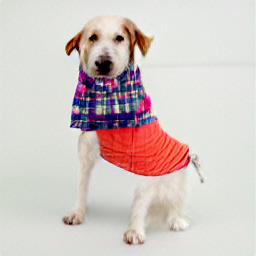

Score: 25.09



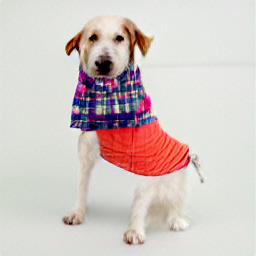

Score: 25.09



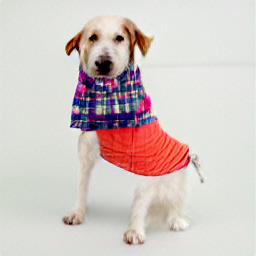

Score: 25.09



In [27]:
text_description = "Dog wearing clothes"
generate_text_to_image(text_description)

  0%|          | 0/3 [00:00<?, ?it/s]

Prompt: An astronaut relaxing beside a sweeping pool.



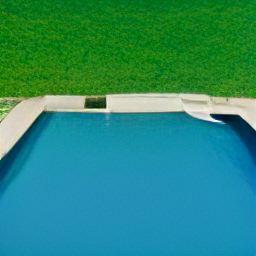

Score: 25.14



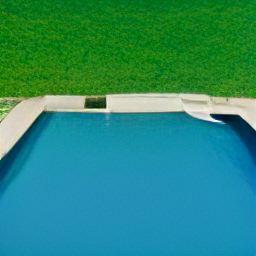

Score: 25.14



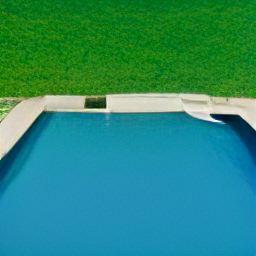

Score: 25.14



In [28]:
text_description = "An astronaut relaxing beside a sweeping pool."
generate_text_to_image(text_description)

  0%|          | 0/1 [00:00<?, ?it/s]

Prompt: Man sitting on top of a cat.



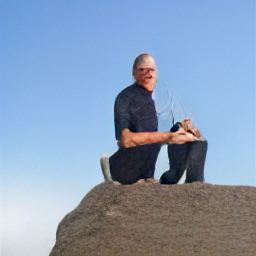

Score: 24.45



In [32]:
text_description = "Man sitting on top of a cat."
generate_text_to_image(text_description)

  0%|          | 0/1 [00:00<?, ?it/s]

Prompt: A Cat with a hat.



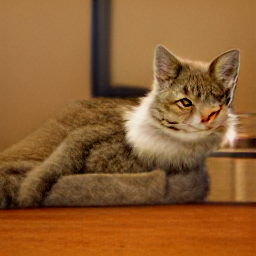

Score: 20.84



In [33]:
text_description = "A Cat with a hat."
generate_text_to_image(text_description)